In [16]:
import re
import math
from typing import List, Tuple, Dict, Any, Literal, Union
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import warnings

warnings.filterwarnings("ignore")

CACHE_DIR = './.cache'

In [3]:
ds = load_dataset("UniverseTBD/arxiv-abstracts-large")


In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [5]:
for i in range(3):
    print(f"Example: {i+1}")
    print(ds['train'][i]['abstract'])
    print(ds['train'][i]['categories'])
    print('-'*20)

Example: 1
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-p

In [6]:
all_categories = ds['train']['categories']
category_set = set()

for category in all_categories:
    parts = category.split(" ")
    for part in parts:
        topic = part.split(".")[0]
        category_set.add(topic)

# sort the label
sorted_categories = sorted(list(category_set), key = lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset')
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [7]:
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue
    current_category = s['categories'].split('.')[0]

    if current_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 1000:
        break


In [8]:
preprocessed_samples = []

for s in samples:

    abstract = s['abstract']

    # remove \n characters
    abstract = abstract.strip().replace('\n', " ")

    # remove special characters and digits
    abstract = re.sub(r"[^a-zA-Z\s]", "", abstract)

    # convert to lower case
    abstract = abstract.lower()

    parts = s['categories'].split(' ')
    primary_category = parts[0].split('.')[0]

    preprocessed_samples.append({
        'abstract': abstract,
        'category': primary_category
    })

preprocessed_samples[:3]


[{'abstract': 'the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field  american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about  km at  billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is  x  sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about  x  rad s',
  'category': 'physics'},
 {'abstract': 'we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection f

In [18]:
labels = set(s['category'] for s in preprocessed_samples)
sorted_labels = sorted(labels)

id_to_label = {i: label for i, label in enumerate(sorted_labels)}
label_to_id = {label: i for i, label in enumerate(sorted_labels)}

print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")


Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [ ]:
# prepare data for training and testing
X = [preprocessed_samples[i]['abstract'] for i in range(len(preprocessed_samples))]
y = [preprocessed_samples[i]['category'] for i in range(len(preprocessed_samples))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# embedding vectorizer class
class EmbeddingVectorizer:
    def __init__(self,
                model_name: str = 'intfloat/multilingual-e5-base',
                normalize: bool = True     
           ):
        self.model = SentenceTransformer(model_name, cache_folder=CACHE_DIR)
        self.normalize = normalize
    
    def _format_input(self, texts: List[str], mode: Literal['query', 'passage']) -> List[str]:
        if mode not in ['query', 'passage']:
            raise ValueError("Mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]
    
    def transform(self, texts: List[str], mode: Literal['query', 'passage'] = 'passage') -> List[List[float]]:
        if mode == "raw":
            inputs = texts
        else:
            inputs = self._format_input(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()
    
    def transform_numpy(self, texts: List[str], mode: Literal['query', 'passage'] = 'query') -> np.array:
        return np.array(self.transform(texts, mode))
        

In [33]:
# preprocessing

# BOW vectorization
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF vectorization
tf_idf_vectorizer = TfidfVectorizer()
X_train_tfidf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)

# embedding vectorization
embedding_vectorizer = EmbeddingVectorizer()
X_train_embd = embedding_vectorizer.transform_numpy(X_train)
X_test_embd = embedding_vectorizer.transform_numpy(X_test)

# Convert all to numpy arrays
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())
X_train_tfidf, X_test_tfidf = np.array(X_train_tfidf.toarray()), np.array(X_test_tfidf.toarray())


In [34]:
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}\n")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}\n")
print(f"Shape of X_train_embeddings: {X_train_embd.shape}")
print(f"Shape of X_test_embeddings: {X_test_embd.shape}\n")


Shape of X_train_bow: (800, 10174)
Shape of X_test_bow: (200, 10174)

Shape of X_train_tfidf: (800, 10174)
Shape of X_test_tfidf: (200, 10174)

Shape of X_train_embeddings: (800, 768)
Shape of X_test_embeddings: (200, 768)



In [42]:
# kmeans clustering
# group the vectors into k clusters then label each cluster based on the most popular label in that cluster

def train_and_test_kmeans(X_train, X_test, y_train, y_test, n=5):
    kmeans = KMeans(n_clusters=n, random_state=42)
    clusters_id = kmeans.fit_predict(X_train)

    cluster_to_label = {}

    for cluster_id in set(clusters_id):
        labels_in_cluster = [y_train[i] for i in range(len(y_train)) if clusters_id[i] == cluster_id]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    test_clusters_id = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_clusters_id]
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True)

    return y_pred, accuracy, report

In [43]:
# KNN classification
def train_and_test_knn(X_train, X_test, y_train, y_test, n=5):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True)
    return y_pred, accuracy, report

In [44]:
# Decision Tree Classification
def train_and_test_tree(X_train, X_test, y_train, y_test, max_depth=None):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

    tree.fit(X_train_dense, y_train)
    y_pred = tree.predict(X_test_dense)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True)
    return y_pred, accuracy, report

In [45]:
# Naive Bayes Classification
def train_and_test_NB(X_train, X_test, y_train, y_test):
    nb = GaussianNB()
    
    # NB requires dense input
    X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

    nb.fit(X_train_dense, y_train)
    y_pred = nb.predict(X_test_dense)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True)
    return y_pred, accuracy, report

In [57]:
def plot_confusion_matrix(y_true, y_pred, labels_list, figure_name="confusion_matrix", normalize="true", save_path=None, show=True):
    # compute cm with exact order provided
    cm = confusion_matrix(y_true, y_pred)

    # normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    labels = np.unique(y_true)
    class_names = [labels_list[i] for i in range(len(labels_list)) if labels_list[i] in labels]

    annotation = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i, j]
            norm = cm_normalized[i, j]
            annotation[i, j] = f"{raw}\n{norm:.2%}"

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=annotation, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(figure_name)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)  
    if show:
        plt.show()

    
    


In [63]:
def train():

    results = defaultdict(dict)
    
    feature_sets = {
    'BoW': {"X_train": X_train_bow, "X_test": X_test_bow},
    'TF-IDF': {"X_train": X_train_tfidf, "X_test": X_test_tfidf},
    'Embeddings': {"X_train": X_train_embd, "X_test": X_test_embd}
}    
    models = ["KNN", "KMeans", "GaussianNB", "DecisionTree"]

    for model in models:
        print(f"\nClassification using {model} model: ")
        print("-"*20)
        for method, training_set in feature_sets.items():
            print(f"Vectorization method: {method}:")
            X_train = training_set["X_train"]
            X_test = training_set["X_test"]

            if model == "KNN":
                y_pred, acc, cm = train_and_test_knn(X_train, X_test, y_train, y_test)
            elif model == "KMeans":
                y_pred, acc, cm = train_and_test_kmeans(X_train, X_test, y_train, y_test, n=len(np.unique(y_train)))
            elif model == "GaussianNB":
                y_pred, acc, cm = train_and_test_NB(X_train, X_test, y_train, y_test)
            elif model == "DecisionTree":
                y_pred, acc, cm = train_and_test_tree(X_train, X_test, y_train, y_test)

            results[model][method] = acc
            
            print(f"{method}: {acc:.4f}")

            plot_confusion_matrix(y_test, y_pred, sorted_labels, f"Confusion Matrix for {model} and {method}")
    
    return results




Classification using KNN model: 
--------------------
Vectorization method: BoW:
BoW: 0.5350


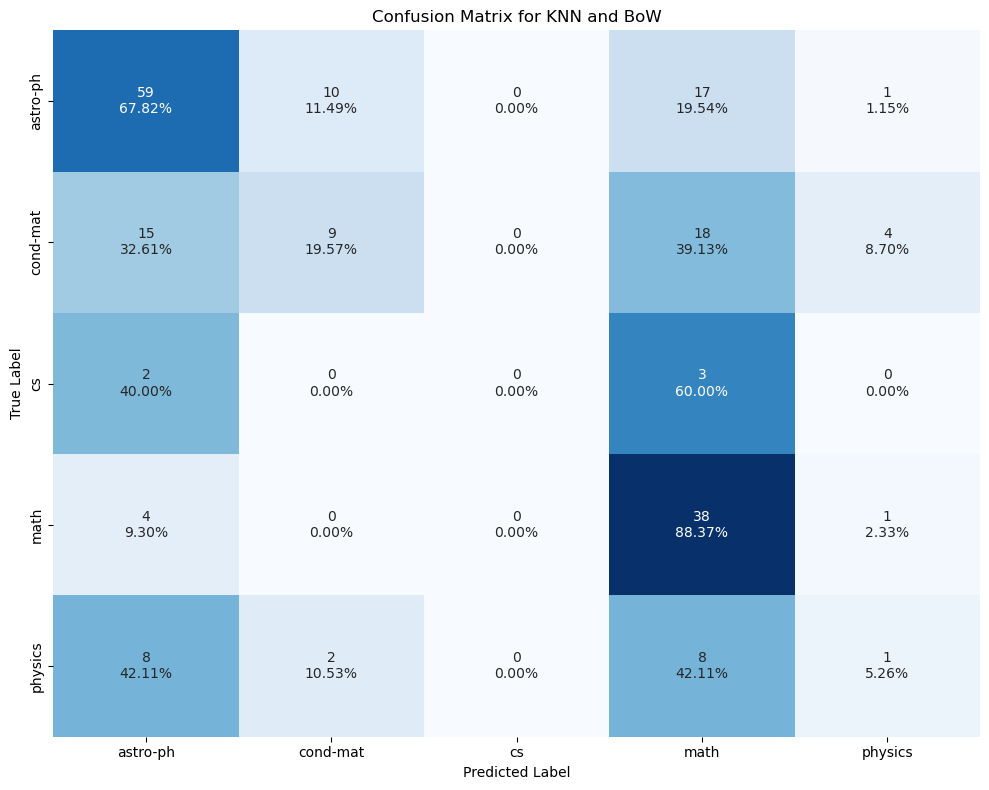

Vectorization method: TF-IDF:
TF-IDF: 0.7900


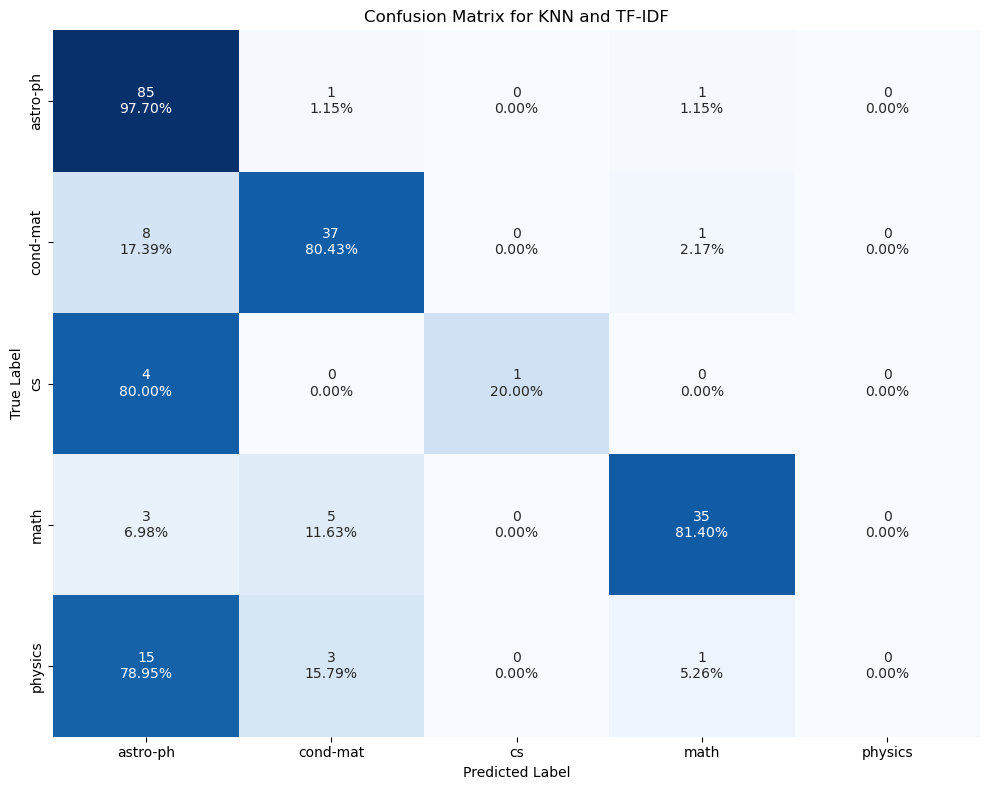

Vectorization method: Embeddings:
Embeddings: 0.8550


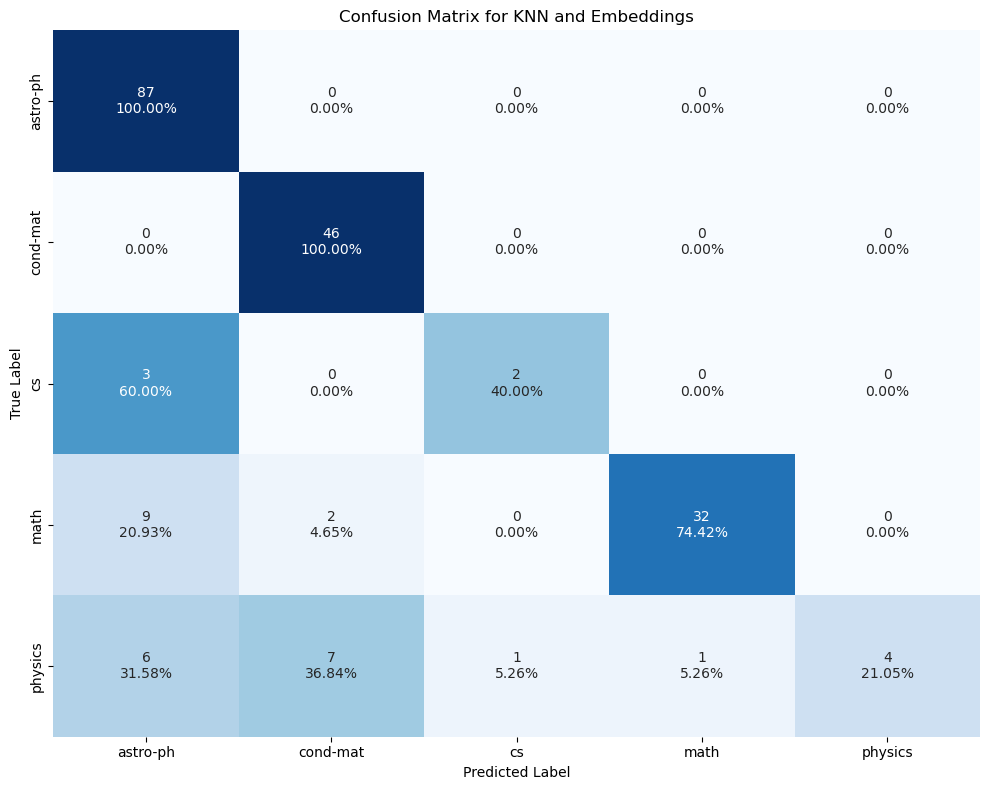


Classification using KMeans model: 
--------------------
Vectorization method: BoW:
BoW: 0.5000


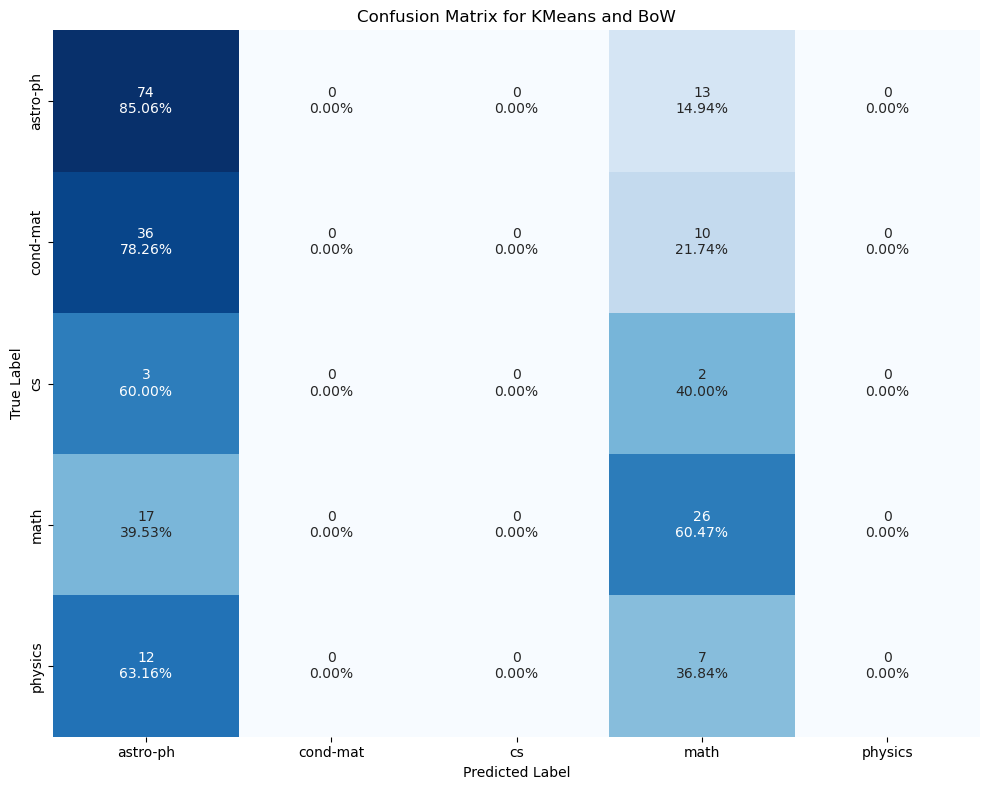

Vectorization method: TF-IDF:
TF-IDF: 0.5650


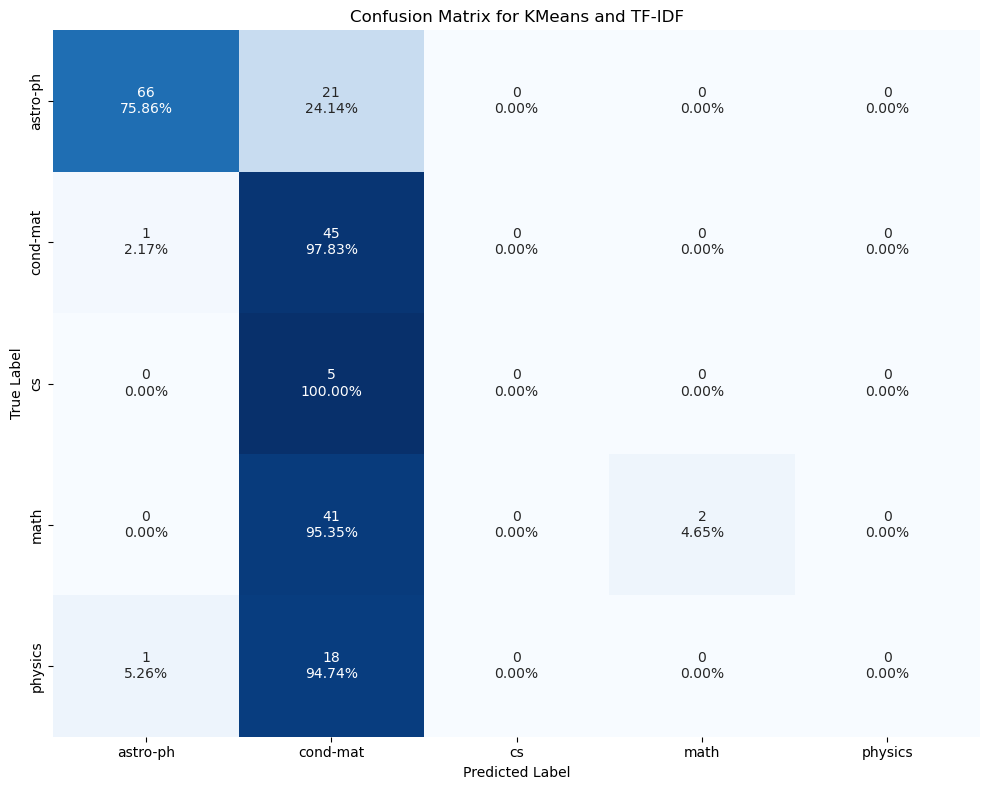

Vectorization method: Embeddings:
Embeddings: 0.7600


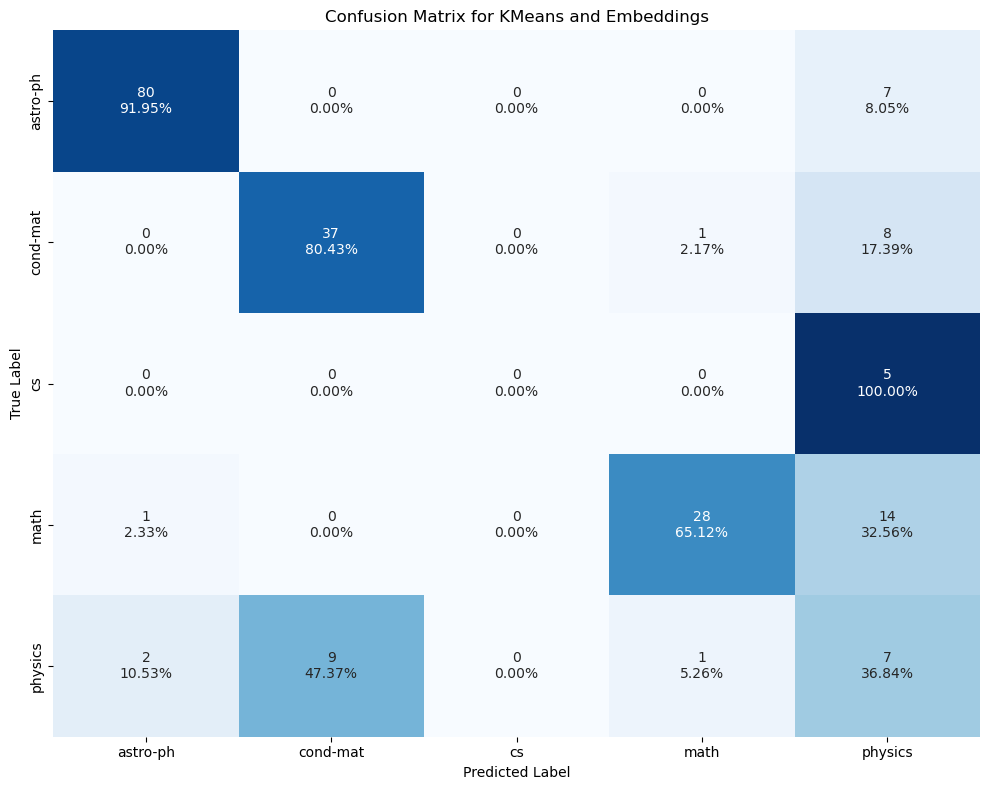


Classification using GaussianNB model: 
--------------------
Vectorization method: BoW:
BoW: 0.7750


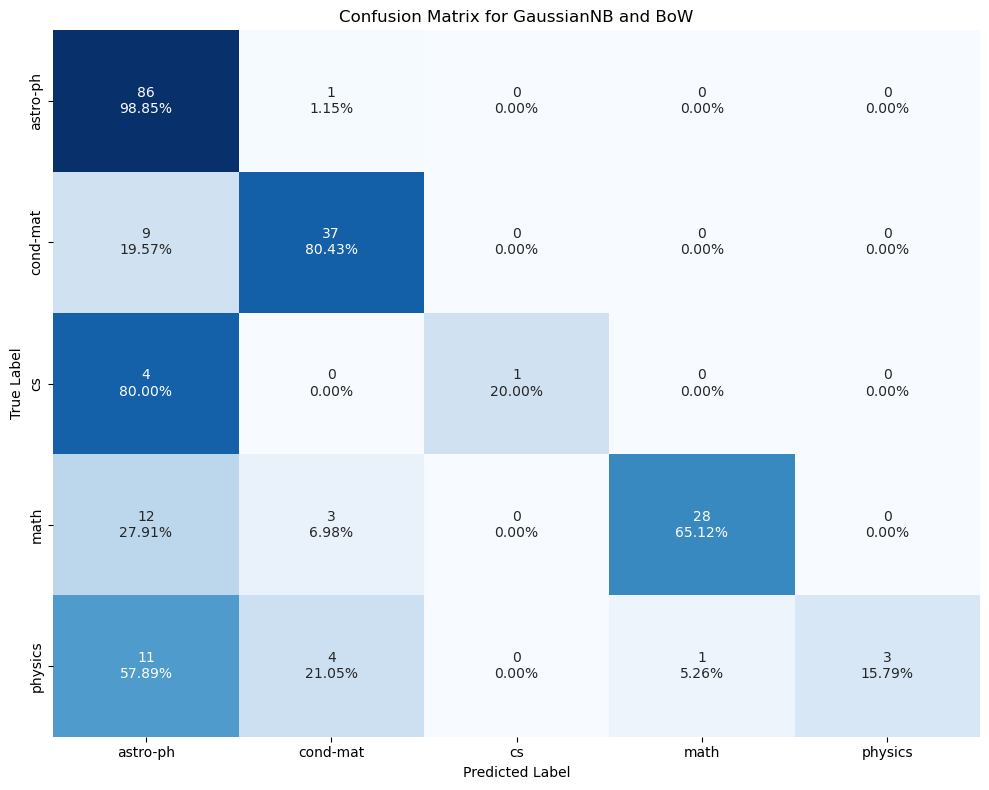

Vectorization method: TF-IDF:
TF-IDF: 0.7900


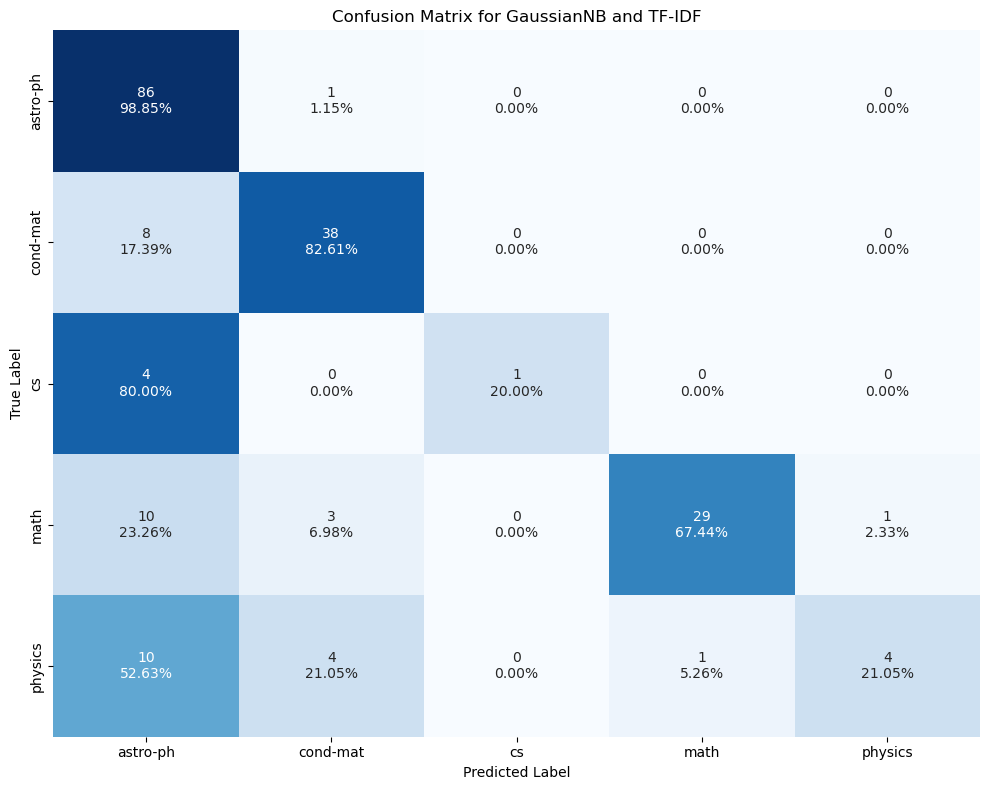

Vectorization method: Embeddings:
Embeddings: 0.8650


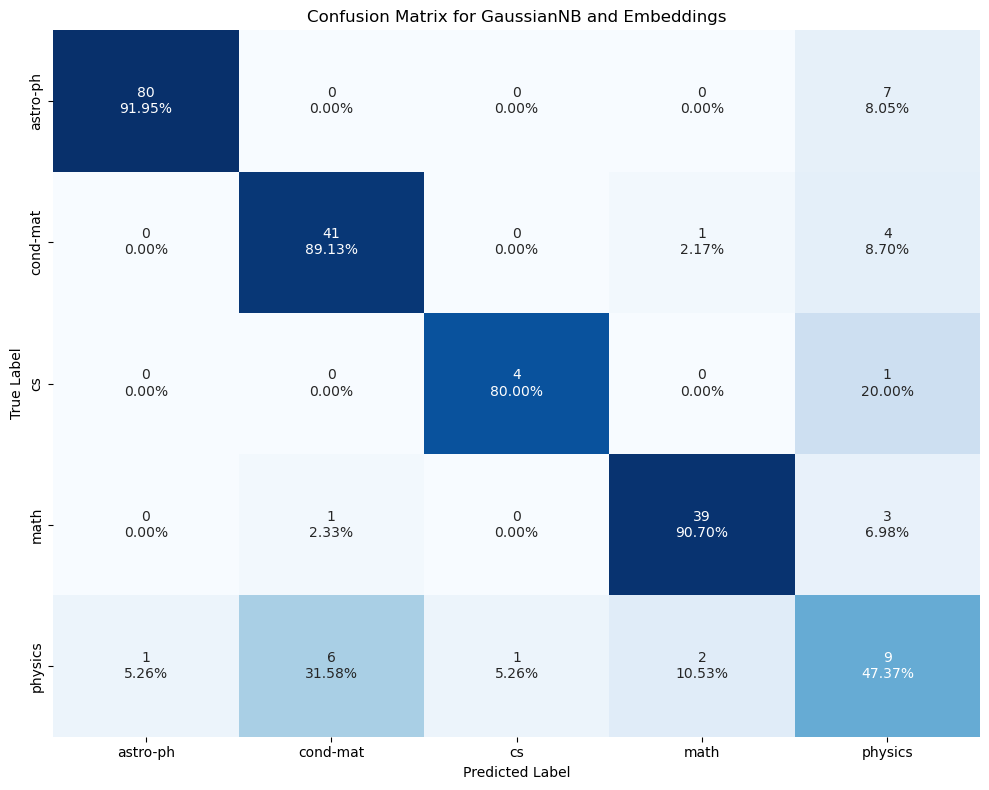


Classification using DecisionTree model: 
--------------------
Vectorization method: BoW:
BoW: 0.6250


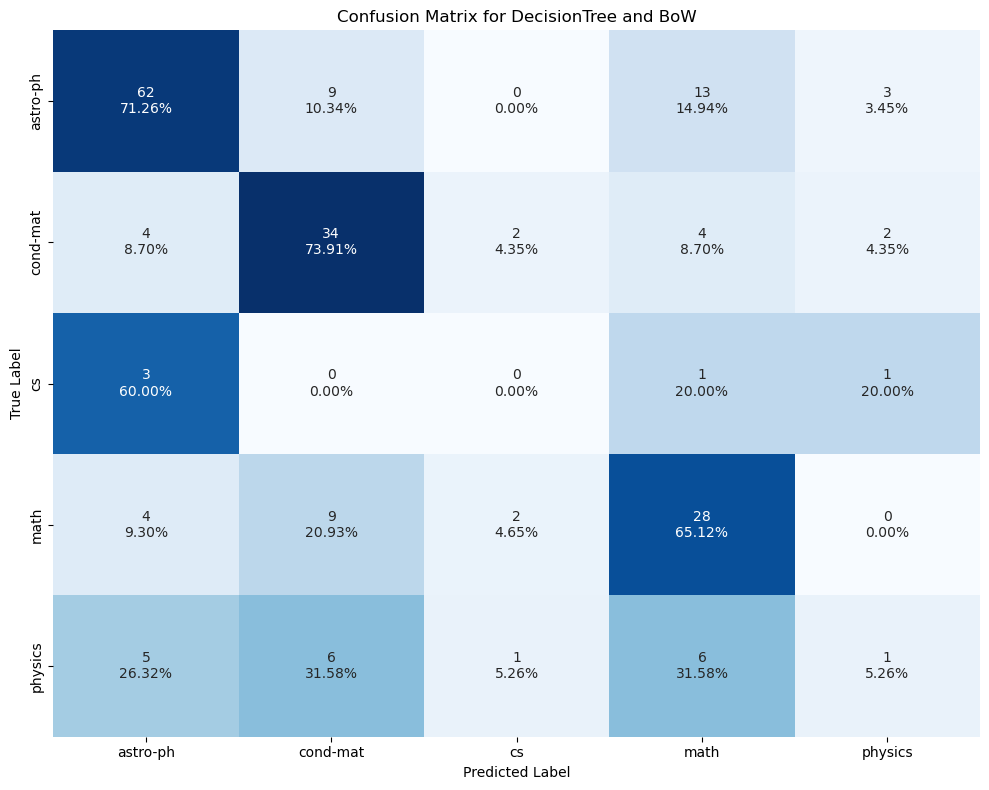

Vectorization method: TF-IDF:
TF-IDF: 0.6150


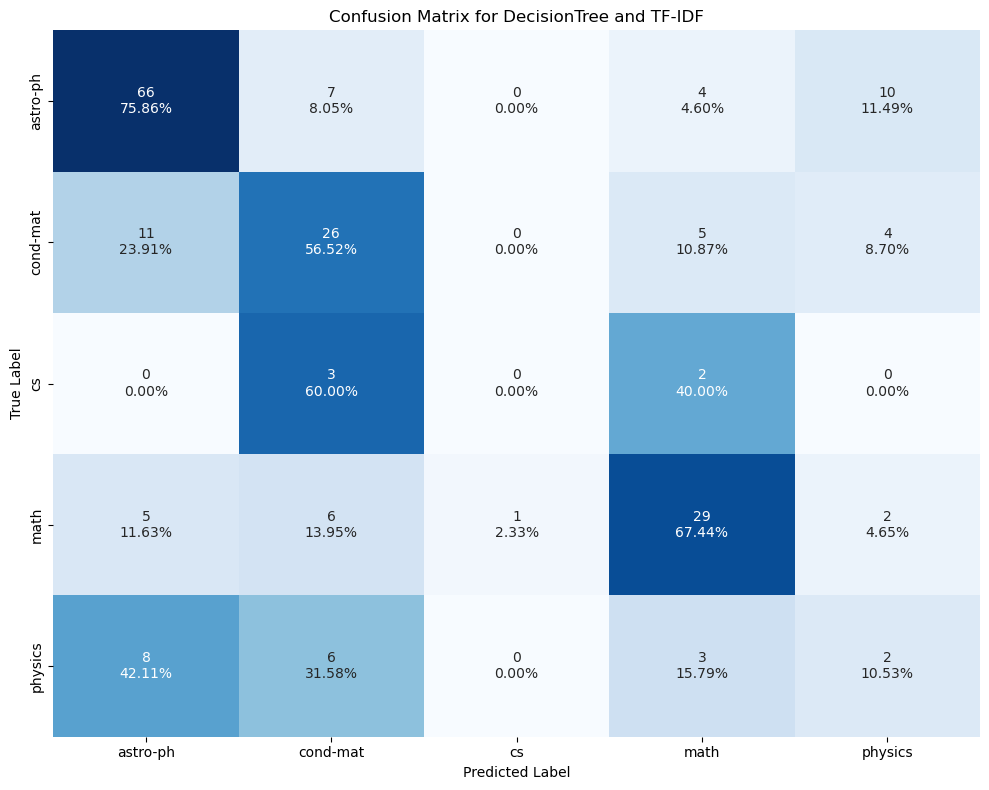

Vectorization method: Embeddings:
Embeddings: 0.6250


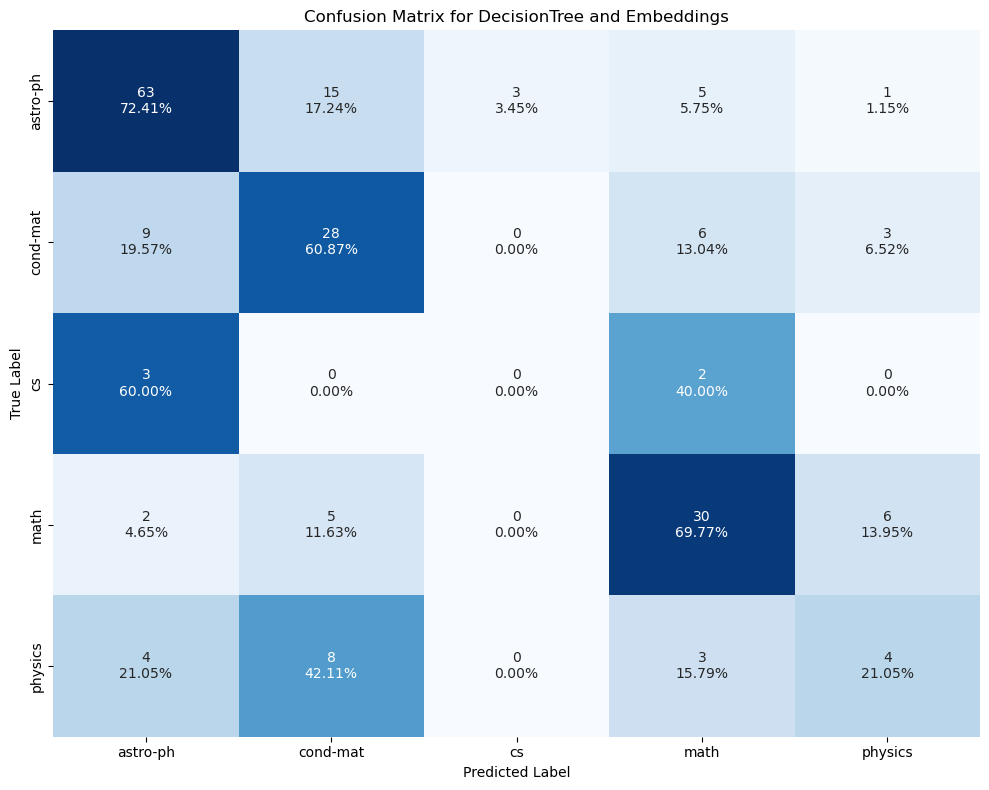

In [64]:
results = train()

In [69]:
# display the results in a table
import pandas as pd
pd.DataFrame(results)

,KNN,KMeans,GaussianNB,DecisionTree
BoW,0.535,0.500,0.775,0.625
TF-IDF,0.790,0.565,0.790,0.615
Embeddings,0.855,0.760,0.865,0.625
